In [ ]:
import pandas as pd

splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}
df_train = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"]).sample(frac=1)
df_validation = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"]).sample(frac=1)
df_test = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"]).sample(frac=1)

print(df_train.head(), '\n')
print(df_validation.head(), '\n')
print(df_test.head(), '\n')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                                   text  label
452              disturbing and brilliant documentary .      1
6429  not so much funny as aggressively sitcom-cute ...      0
2933  smart , funny and just honest enough to provid...      1
1767  the result is more depressing than liberating ...      1
3532  an unsettling , memorable cinematic experience...      1 

                                                   text  label
455   . . . even if you've never heard of chaplin , ...      1
290   what one is left with , even after the most aw...      1
194   it's a good film , but it falls short of its a...      1
903   there's surely something wrong with a comedy w...      0
1012                   more precious than perspicacious      0 

                                                  text  label
837   competently directed but terminally cute drama .      0
989  the film has too many spots where it's on slip...      0
845  in terms of execution this movie is careless a...

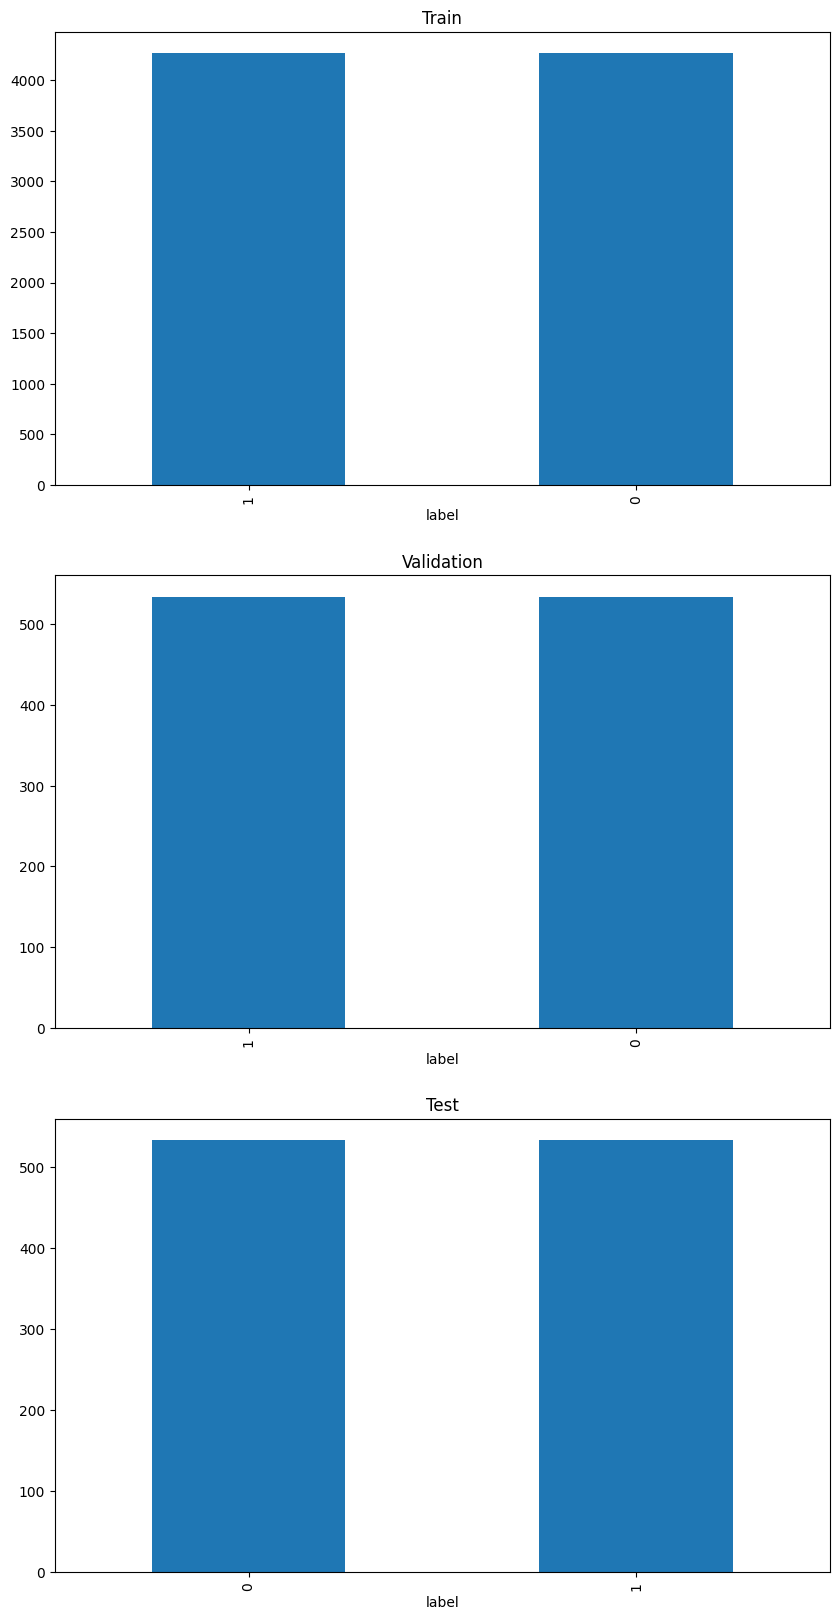

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))

plt.subplot(3,1,1)
df_train.label.value_counts().plot(kind='bar')
plt.title('Train')

plt.subplot(3,1,2)
df_validation.label.value_counts().plot(kind='bar')
plt.title('Validation')

plt.subplot(3,1,3)
df_test.label.value_counts().plot(kind='bar')
plt.title('Test')
plt.show()

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the function row-wise and convert the results to a list of dictionaries
tokenized_train = df_train.apply(tokenize_function, axis=1).tolist()
tokenized_validation = df_validation.apply(tokenize_function, axis=1).tolist()
tokenized_test = df_test.apply(tokenize_function, axis=1).tolist()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class RottenTomatoesDataset:
  def __init__(self, tokenized_data):
    # Assuming tokenized_data is a list of dictionaries, where each dictionary
    # contains 'input_ids', 'token_type_ids', and 'attention_mask' for a single example.
    self.input_ids = [item['input_ids'] for item in tokenized_data]
    self.token_type_ids = [item['token_type_ids'] for item in tokenized_data]
    self.attention_mask = [item['attention_mask'] for item in tokenized_data]
    # Assuming the labels are still in the original dataframes.
    # We need to get the labels from the original dataframes.
    # Let's assume the order of tokenized_data corresponds to the original dataframes.
    # This might be risky if the order is not preserved. A safer approach
    # would be to include the label in the tokenized_data during the tokenization step.
    self.labels = [item['labels'] for item in tokenized_data]


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return {'input_ids': self.input_ids[idx], 'token_type_ids': self.token_type_ids[idx], 'attention_mask': self.attention_mask[idx], 'labels': self.labels[idx]}

# We need to make sure the labels are aligned with the tokenized data.
# Let's modify the tokenization function to include labels.
def tokenize_function_with_labels(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokenized['labels'] = examples["label"]
    return tokenized

# Re-apply the function and convert to a list of dictionaries
tokenized_train = df_train.apply(tokenize_function_with_labels, axis=1).tolist()
tokenized_validation = df_validation.apply(tokenize_function_with_labels, axis=1).tolist()
tokenized_test = df_test.apply(tokenize_function_with_labels, axis=1).tolist()


train_dataset = RottenTomatoesDataset(tokenized_train)
validation_dataset = RottenTomatoesDataset(tokenized_validation)
test_dataset = RottenTomatoesDataset(tokenized_test)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    report_to="none", # Disable wandb logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.444000,0.444505,0.822702
2,0.271600,0.499729,0.821764
3,0.158500,0.667276,0.848030
4,0.095600,0.779587,0.845216
5,0.036400,0.956922,0.851782
6,0.018700,1.047248,0.844278
7,0.019000,1.123462,0.848968
8,0.011600,1.129541,0.854597
9,0.010300,1.161500,0.848030
10,0.009500,1.139480,0.851782


TrainOutput(global_step=5340, training_loss=0.10078407011451793, metrics={'train_runtime': 7717.9928, 'train_samples_per_second': 11.052, 'train_steps_per_second': 0.692, 'total_flos': 2.2443373022208e+16, 'train_loss': 0.10078407011451793, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 1.1950838565826416, 'eval_accuracy': 0.8461538461538461, 'eval_runtime': 29.8694, 'eval_samples_per_second': 35.689, 'eval_steps_per_second': 2.243, 'epoch': 10.0}


In [ ]:
print("\nEvaluating model on validation set:")
eval_results = trainer.evaluate()
print(eval_results)

print("\nPredicting on test set:")
predictions = trainer.predict(test_dataset)

print("\nTest set metrics:")
test_metrics = compute_metrics((predictions.predictions, predictions.label_ids))
test_metrics


Evaluating model on validation set:


{'eval_loss': 1.1394798755645752, 'eval_accuracy': 0.851782363977486, 'eval_runtime': 29.658, 'eval_samples_per_second': 35.943, 'eval_steps_per_second': 2.259, 'epoch': 10.0}

Predicting on test set:

Test set metrics:


{'accuracy': 0.8461538461538461}

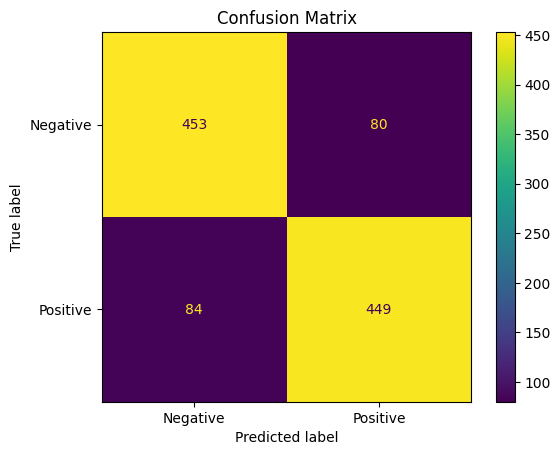

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# classification report

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])

# Print the classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.85       533
    Positive       0.85      0.84      0.85       533

    accuracy                           0.85      1066
   macro avg       0.85      0.85      0.85      1066
weighted avg       0.85      0.85      0.85      1066



In [ ]:
# some examples of test cases

print("\nExample Test Cases:")
for i in range(12): # Print the first 12 test examples
    text = df_test['text'].iloc[i]
    true_label = df_test['label'].iloc[i]
    predicted_label = predicted_labels[i]

    print(f"Text: {text}")
    print(f"Actual Label: {true_label} ({'Positive' if true_label == 1 else 'Negative'})")
    print(f"Predicted Label: {predicted_label} ({'Positive' if predicted_label == 1 else 'Negative'})")
    print("-" * 20)



Example Test Cases:
Text: competently directed but terminally cute drama .
Actual Label: 0 (Negative)
Predicted Label: 1 (Positive)
--------------------
Text: the film has too many spots where it's on slippery footing , but is acceptable entertainment for the entire family and one that's especially fit for the kiddies .
Actual Label: 0 (Negative)
Predicted Label: 1 (Positive)
--------------------
Text: in terms of execution this movie is careless and unfocused .
Actual Label: 0 (Negative)
Predicted Label: 0 (Negative)
--------------------
Text: an older cad instructs a younger lad in zen and the art of getting laid in this prickly indie comedy of manners and misanthropy .
Actual Label: 1 (Positive)
Predicted Label: 1 (Positive)
--------------------
Text: it should be interesting , it should be poignant , it turns out to be affected and boring .
Actual Label: 0 (Negative)
Predicted Label: 0 (Negative)
--------------------
Text: the beautiful images and solemn words cannot disguise the 